# Raport - Task A

I'm working on Heart Attack dataset.
I found better description of variables than on kaggle:
https://www.hindawi.com/journals/cmmm/2017/8272091/tab1/

Target variable: 
* 0 = less chance of heart attack
* 1 = more chance of heart attack

## 4.
First two (random) observations provide different variables of the highest importance. In the first case the variable with the highest importance is `caa` indicating number of major vessels (the more colored by fluoroscopy the better for the patient). On the other hand, in the second case, this variable is `oldpeak` telling us about the previous peak (from what I've read the greater the value the higher chance of the heart attack).

![](https://drive.google.com/uc?export=view&id=13VKF6IChIVdO5PaJuBsQQAXCxIxWrTGL)

## 5.
For the aforementioned examples we can spot `age` variable, which shap value in the first case is negative and even third most important. It's quite surprising and counterintuitive, that for the person who is 63, age lower the chance of the heart attack. Similarly, in the second case, I can't explain it as well. Age 37 (quite low) increases the probability of the heart attack (shap value is positive). (FEEDBACK APPRECIATED)

## 6. 
The difference between explanations predicted by dalex and shap packages are rather small - for the most important variables, the difference in attribution is generally negligible. However, less important variables can differ.

It's worth noticing that there is possibility we might have used different algorithms - shap is using TreeSHAP and dalex automatically chooses an algorithm).

![](https://drive.google.com/uc?export=view&id=11DXHcU5wV-5DaoGwAqApsd8_M0N7jGBB)

![](https://drive.google.com/uc?export=view&id=100hk00DLga1JWv2uBFXel-RS-e1H9DG3)


## 7.
We can train and compare a logistic regression model from the previous homework, predicting it might use different features than our XGBoost model.

And indeed, obtained results are quite different. For instance, for the first example the most important variable is `thall` instead of `caa`. In the second case the most important variable is the same. Both models have some similar variables of highest importance, but for the most part taken features differs.

![](https://drive.google.com/uc?export=view&id=1wIFH7eTr9bZOGn3GFC6vDYvkWROjk6b_)

# Task B

Based on the equation from the lecture:
$\phi(A) = \frac{1}{6}(20\cdot 2+40+10+30\cdot 2) = \frac{150}{6}=25$

# Appendix

## Import packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix,\
  ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

import dalex as dx
import xgboost as xgb
import shap

SEED = 42

## Load data

In [2]:
!gdown 14RnHkHVRmZHdXF7_THt7arQzlzplKbF1

Downloading...
From: https://drive.google.com/uc?id=14RnHkHVRmZHdXF7_THt7arQzlzplKbF1
To: /content/heart.csv
100% 11.3k/11.3k [00:00<00:00, 11.9MB/s]


In [3]:
df_raw = pd.read_csv('heart.csv')
df_raw.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data preprocessing

In [4]:
df_raw.info() # only int and float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
print(df_raw.shape) # 303 observations, 14 variables (including one output class)
df_raw.describe()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Based on the data and documentation from kaggle we should apply one-hot encoding transformation to the following variables: `cp`, `restecg`.

In [6]:
df = pd.get_dummies(df_raw, columns=['cp', 'restecg'])
df.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,slp,caa,thall,output,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2
0,63,1,145,233,1,150,0,2.3,0,0,1,1,0,0,0,1,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,2,1,0,0,1,0,0,1,0
2,41,0,130,204,0,172,0,1.4,2,0,2,1,0,1,0,0,1,0,0
3,56,1,120,236,0,178,0,0.8,2,0,2,1,0,1,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,2,0,2,1,1,0,0,0,0,1,0


In [7]:
X = df.drop('output', axis=1)
y = df.output

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

With stratify argument we can assure than the proportion of values in the sample produced will be the same as the proportion of values in `y`.

Also, I decided to standardize features by removing the mean and scaling to unit variance. We don't want a feature that has a variance that is orders of magnitude larger than others.

For now I will use just train/test split, in the future I can extend it with train/val/test split if needed.

## Train a XGBoost model

In [18]:
BST_model = xgb.XGBClassifier(random_state=SEED, max_depth=2).fit(X, y)

## dalex

In [53]:
pf_xgboost_classifier_default = lambda m, d: m.predict_proba(d)[:, 1]
explainer = dx.Explainer(BST_model, X, y, predict_function=pf_xgboost_classifier_default, label="GBM")

Preparation of a new explainer is initiated

  -> data              : 303 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : GBM
  -> predict function  : <function <lambda> at 0x7f77e08998c0> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00365, mean = 0.545, max = 0.996
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.93, mean = -0.000146, max = 0.848
  -> model_info        : package xgboost

A new explainer has been created!


Check performance

In [54]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
GBM,0.933333,0.905882,0.919403,0.910891,0.976943


In [55]:
explainer.predict(X.iloc[0:2])

array([0.69278663, 0.8955764 ], dtype=float32)

In [22]:
shap_attributions = [explainer.predict_parts(X.iloc[[i]], type="shap", label=f'obs {i}') for i in range(2)]

In [34]:
shap_attributions[0].plot(shap_attributions[1])

## shap

In [37]:
shap_explainer = shap.explainers.Tree(BST_model, data=X, model_output="probability")
shap_values = shap_explainer(X)

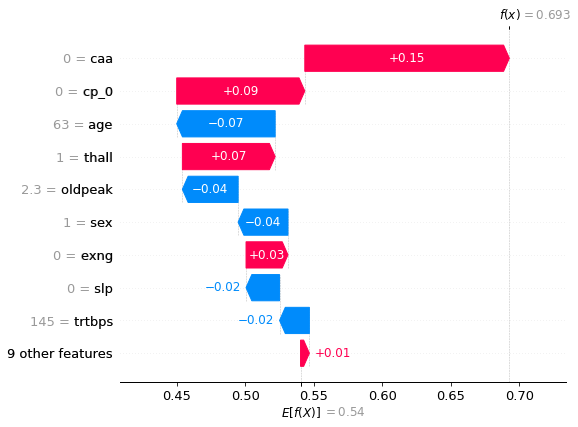

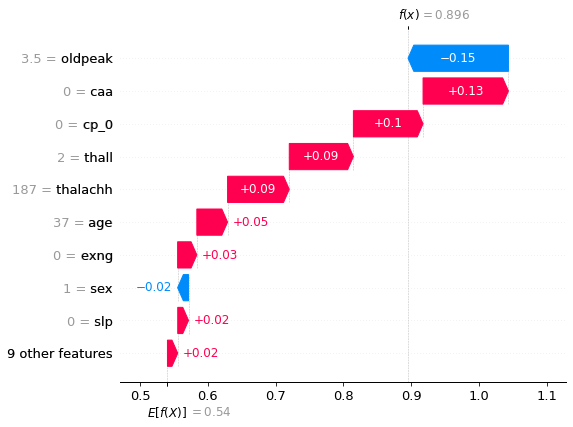

In [39]:
for i in range(2):
    shap.plots.waterfall(shap_values[i])

## Logistic regression (another model)

In [42]:
LR_model = LogisticRegression(class_weight='balanced', max_iter=1500, random_state=SEED).fit(X, y)
explainer = dx.Explainer(LR_model, X, y, predict_function=pf_xgboost_classifier_default, label="LR")

Preparation of a new explainer is initiated

  -> data              : 303 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : LR
  -> predict function  : <function <lambda> at 0x7f77e5d654d0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00139, mean = 0.524, max = 0.996
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.954, mean = 0.0203, max = 0.964
  -> model_info        : package sklearn

A new explainer has been created!


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



In [43]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
LR,0.90303,0.837079,0.868805,0.851485,0.926087


In [46]:
explainer.predict(X.iloc[0:2])

array([0.65718147, 0.69686751])

In [47]:
shap_attributions = [explainer.predict_parts(X.iloc[[i]], type="shap", label=f'obs {i}') for i in range(2)]

In [48]:
shap_attributions[0].plot(shap_attributions[1])